In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from utils.data import load_tc_data
from utils.plot import make_cmap
import cftime as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from numpy import inf
# from utils.evaluation import find_landfalling_tcs,tc_region

In [2]:
precip_cmap,precip_norm = make_cmap()
levels = [10, 15, 20, 25, 30, 40, 50,75, 100]

In [3]:
# open storm dataset
tc_dir = '/user/home/al18709/work/event_sets/wgan_scalar/'
storm_filename = 'validation_2006237N13298.nc'
storm = xr.open_dataset(tc_dir + storm_filename)

tc_dir_truth = '/user/home/al18709/work/event_sets/truth/'
storm_truth = xr.open_dataset(tc_dir_truth + storm_filename)

In [4]:
# define initial variables
precip_cmap,precip_norm = make_cmap()

lats = storm.storm_lats[0,:,:]
lons = storm.storm_lons[0,:,:]

levels = [10, 15, 20, 25, 30, 40, 50,75, 100]
sns.set_style("white")
sns.set_context("notebook")
vmin=0
vmax=100

print(lats.shape)
print(lons.shape)


ntime,_,_,_ = storm.precipitation.shape
rain = storm.precipitation[0,:,:,0]
rain_truth = storm_truth.precipitation[0,:,:,0]


(100, 100)
(100, 100)


In [5]:
# find storm extent
fp = '/bp1store/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
d = Dataset(fp, 'r')
lat = d.variables['lat'][:] #lat
lon = d.variables['lon'][:] #lon
lat_lower_bound = (np.abs(lat-np.min(storm.storm_lats))).argmin()
lat_upper_bound = (np.abs(lat-np.max(storm.storm_lats))).argmin()
lon_lower_bound = (np.abs(lon-np.min(storm.storm_lons))).argmin()
lon_upper_bound = (np.abs(lon-np.max(storm.storm_lons))).argmin()

lats = lat[lat_lower_bound:lat_upper_bound+2]
lons = lon[lon_lower_bound:lon_upper_bound+2]
grid_x, grid_y = np.meshgrid(lons,lats)
print(grid_x.shape)
print(grid_y.shape)

(326, 252)
(326, 252)


In [6]:
# superimpose rain onto bigger grid
grid_rain = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1]))
grid_rain_truth = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1]))

for t in range(ntime):

	storm_lons = storm.storm_lons[t,:,:]
	storm_lats = storm.storm_lats[t,:,:]
	storm_rain = storm.precipitation[t,:,:,0]
	storm_rain_truth = storm_truth.precipitation[t,:,:,0]

	Mlon = storm_lons[-1,-1]
	mlon = storm_lons[0,0]
	Mlat = storm_lats[-1,-1]
	mlat = storm_lats[0,0]
	Xspan = np.where((grid_x <= Mlon) & (grid_x >= mlon))[1][[0, -1]]
	Yspan = np.where((grid_y <= Mlat) & (grid_y >= mlat))[0][[0, -1]]

	# Create a selection
	sel = [slice(Xspan[0], Xspan[1] + 1), slice(Yspan[0], Yspan[1] + 1)]
	# sel = [slice(Xspan[0] - 1, Xspan[1]), slice(Yspan[0] - 1, Yspan[1])]
	# sel = [slice(Yspan[0] -1, Yspan[1] + 1), slice(Xspan[0]-1, Xspan[1] + 1)]

	# grid_rain[t,sel[0],sel[1]] = storm_rain
	grid_rain[t,sel[1],sel[0]] = storm_rain
	grid_rain_truth[t,sel[1],sel[0]] = storm_rain_truth
	

In [7]:
total_storm_rain = np.sum(grid_rain,axis=0)
total_storm_rain_truth = np.sum(grid_rain_truth,axis=0)
rain_bool = total_storm_rain > 50
print(np.sum(rain_bool))
rain_grid_x = grid_x[rain_bool]

rain_bool_truth = total_storm_rain_truth > 50
print(np.sum(rain_bool_truth))
rain_grid_x_truth = grid_x[rain_bool_truth]

5259
5084


In [8]:
hit = (rain_bool == True) & (rain_bool_truth == True)
print(np.sum(hit))
miss = (rain_bool == False) & (rain_bool_truth == True)
hit_rate = np.sum(hit) / (np.sum(hit) + np.sum(miss))
print('Hit rate: ',hit_rate*100)

false_alarm = (rain_bool == True) & (rain_bool_truth == False)
correct_rejection = (rain_bool == False) & (rain_bool_truth == False)
false_alarm_rate = np.sum(false_alarm)/(np.sum(false_alarm) + np.sum(correct_rejection))
print('false alarm rate',false_alarm_rate*100)

# equitable threat score is:
# (hit - random chance) / (the observed rain area exceeding the criterion + model precticted area - hit - random chance)
# where R = the observed rain area exceeding the criterion * (model predicted area / entire verification domain)
# http://cimss.ssec.wisc.edu/goes/comet/threat.html
# ETS = (hits - E) / (hits + misses + false alarms - E)
# E = (number of forecast points * number of observed points) / total number of points possible

n_forecast_points = np.sum(rain_bool == True)
n_observed_points = np.sum(rain_bool_truth == True)
total_points_possible = np.sum((rain_bool_truth == True) | (rain_bool_truth == False))
E = (n_forecast_points*n_observed_points) / total_points_possible
ETS = (np.sum(hit) - E) / (np.sum(hit) + np.sum(miss) + np.sum(false_alarm) - E)
print('ETS: ', ETS)

# The number of forecasts of the event correct by chance, a r , is determined by assuming that the forecasts are totally independent of the observations, and forecast will match the observation only by chance. This is one form of an unskilled forecast, which can be generated by just guessing what will happen. The ETS has a range of -1/3 to 1, but the minimum value depends on the verification sample climatology. For rare events, the minimum ETS value is near 0, while the absolute minimum is obtained if the event has a climatological frequency of 0.5, and there are no hits. If the score goes below 0 then the chance forecast is preferred to the actual forecast, and the forecast is said to be unskilled.

2396
Hit rate:  47.128245476003144
false alarm rate 3.7149011262780918
ETS:  0.271670009863906


In [9]:
def exposure_calc(population, rain,threshold):
	""" number of people exposed to over 200mm in New York"""
	# population[rain['precipitation'] < 200] = 0
	# print('max rain',np.max(rain['precipitation'].values))
	print('max rain',np.max(rain))
	# population = population.where(rain['precipitation'].values > threshold,0)
	population = population.where(rain > threshold,0)
	# exposure = np.nansum(population['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'].values[2])
	pop = population.population.values
	pop[pop == -inf] = 0
	exposure = np.nansum(pop)
	return exposure

In [10]:
accumulated_rain = np.sum(grid_rain,axis=0)


In [11]:
population_file = '/user/home/al18709/work/population/ppp_2020_10km_Aggregated_final.nc'
population_count = xr.load_dataset(population_file)
print(population_count)
data = population_count.population.values * 144
pop = population_count * 144


pop_lats = population_count.lat
pop_lons = population_count.lon
grid_x_pop, grid_y_pop = np.meshgrid(pop_lons,pop_lats)

<xarray.Dataset>
Dimensions:     (lon: 3600, lat: 1800)
Coordinates:
  * lon         (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 180.0
  * lat         (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
Data variables:
    population  (lat, lon) float32 -3.403e+38 -3.403e+38 ... -3.403e+38
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Nov 01 12:12:14 2023: cdo remapnn,mygrid /user/home/al1...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...


/tmp/ipykernel_76162/2558955332.py:4: RuntimeWarning: overflow encountered in multiply
  data = population_count.population.values * 144


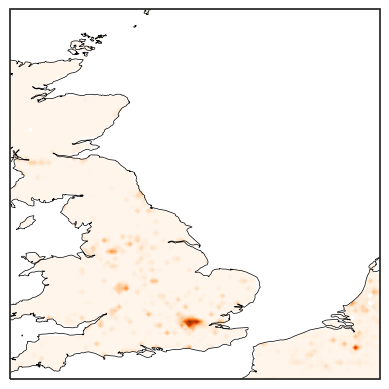

In [12]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
levels = range(1,1500000,20000)
# levels = [1,1000,5000,10000,100000,120000,160000,180000,200000,400000,600000,800000,1000000,2000000,3000000,4000000,5000000]
ax.contourf(lon,-lat + 12,data,levels=levels, transform=ccrs.PlateCarree(),cmap='Oranges')
ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax.set_extent([-5, 5, 50, 60], crs=ccrs.PlateCarree())	
plt.show()

In [13]:
# plt.imshow(data)
print(np.min(data))
data[data == -inf] = 0

-inf


/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, 'title')

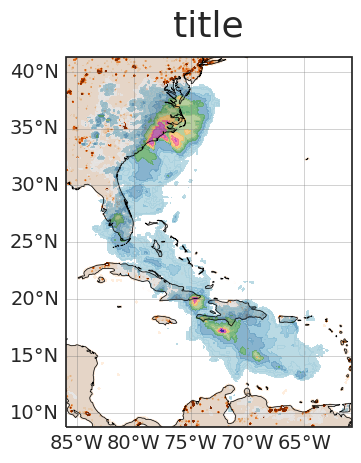

In [14]:
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
sns.set_style("white")
sns.set_context("notebook")
vmin=0
vmax=300


fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

ax.contourf(lon,-lat + 12,data,levels=range(1,200000,20000), transform=ccrs.PlateCarree(),cmap='Oranges')
ax.contourf(grid_x,grid_y,np.sum(grid_rain_truth,axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)
# ax.contourf(grid_x,grid_y,np.sum(grid_rain,axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)


ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)


# plt.contourf(storm.precipitation[0,:,:,0],storm.storm_lats[0,:,:],storm.storm_lons[0,:,:])


# ax.outline_patch.set_linewidth(0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
			linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
# ax.set_xticklabels(labelsize=20)
# ax.set_yticklabels(labelsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

precip_cmap,precip_norm = make_cmap(high_vals=True)
# cbar = plt.colorbar(c,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=ax)
# cbar.ax.tick_params(labelsize=8,width=0.5)
# cbar.ax.tick_params(labelsize=20)

ax.set_extent([grid_x[0,0], grid_x[-1,-1], grid_y[0,0], grid_y[-1,-1]], crs=ccrs.PlateCarree())
ax.set_title('title',fontsize=26,pad=15)

In [15]:
print(grid_x)
print(grid_y)

[[-85.95     -85.85     -85.74999  ... -61.05     -60.95     -60.850002]
 [-85.95     -85.85     -85.74999  ... -61.05     -60.95     -60.850002]
 [-85.95     -85.85     -85.74999  ... -61.05     -60.95     -60.850002]
 ...
 [-85.95     -85.85     -85.74999  ... -61.05     -60.95     -60.850002]
 [-85.95     -85.85     -85.74999  ... -61.05     -60.95     -60.850002]
 [-85.95     -85.85     -85.74999  ... -61.05     -60.95     -60.850002]]
[[ 8.749995  8.749995  8.749995 ...  8.749995  8.749995  8.749995]
 [ 8.850001  8.850001  8.850001 ...  8.850001  8.850001  8.850001]
 [ 8.95      8.95      8.95     ...  8.95      8.95      8.95    ]
 ...
 [41.05     41.05     41.05     ... 41.05     41.05     41.05    ]
 [41.15     41.15     41.15     ... 41.15     41.15     41.15    ]
 [41.25     41.25     41.25     ... 41.25     41.25     41.25    ]]


In [16]:
# exposure
# storm_pop = pop.sel(lat=slice(-lats[-1]+1+12,-lats[0]+12), lon=slice(lons[0],lons[-1]+1))
# print(storm_pop)
# storm_pop_data = storm_pop.population.values
# print(storm_pop_data.shape)
# print(np.sum(grid_rain,axis=0).shape)
# print(grid_x.shape)
print(pop.population.shape)
accumulated_rain = np.sum(grid_rain,axis=0)
accumulated_rain_truth = np.sum(grid_rain_truth,axis=0)


# superimpose rain onto bigger grid
global_rain = np.zeros((pop.population.shape[0],pop.population.shape[1]))
global_rain_truth = np.zeros((pop.population.shape[0],pop.population.shape[1]))

storm_lons = grid_x
storm_lats = grid_y
storm_rain = accumulated_rain
storm_rain_truth = accumulated_rain_truth

Mlon = storm_lons[-1,-1]
mlon = storm_lons[0,0]
Mlat = storm_lats[-1,-1]
mlat = storm_lats[0,0]
grid_X,grid_Y = np.meshgrid(lon,lat)
Xspan = np.where((grid_X <= Mlon) & (grid_X >= mlon))[1][[0, -1]]
Yspan = np.where((grid_Y <= Mlat) & (grid_Y >= mlat))[0][[0, -1]]

# Create a selection
sel = [slice(Xspan[0], Xspan[1] + 1), slice(Yspan[0], Yspan[1] + 1)]

global_rain[sel[1],sel[0]] = storm_rain
global_rain_truth[sel[1],sel[0]] = storm_rain_truth



pred_exposure = exposure_calc(pop,global_rain,150)
truth_exposure = exposure_calc(pop,global_rain_truth,150)


(1800, 3600)
max rain 204.05874865086747
max rain 334.8124869460173


In [17]:
print(pred_exposure)
print(truth_exposure)

6583.291
9932.632


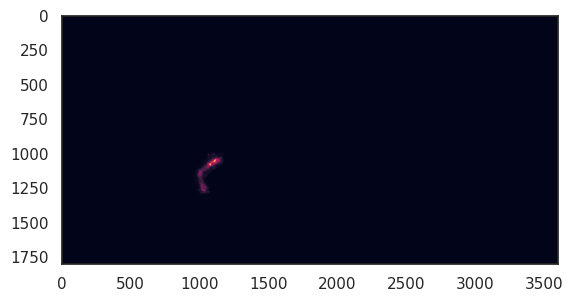

In [18]:
plt.imshow(global_rain)

In [19]:
def ets(total_storm_rain,total_storm_rain_truth,pop):

	rain_bool = total_storm_rain > 50
	# rain_grid_x = grid_X[rain_bool]

	rain_bool_truth = total_storm_rain_truth > 50
	# rain_grid_x_truth = grid_X[rain_bool_truth]

	hit = (rain_bool == True) & (rain_bool_truth == True)
	miss = (rain_bool == False) & (rain_bool_truth == True)
	hit_rate = np.sum(hit) / (np.sum(hit) + np.sum(miss))
	print('Hit rate: ',hit_rate*100)
	pop_hit = np.sum(pop[hit])
	pop_miss = np.sum(pop[miss])
	pop_hit_rate = pop_hit / (pop_hit + pop_miss)


	false_alarm = (rain_bool == True) & (rain_bool_truth == False)
	correct_rejection = (rain_bool == False) & (rain_bool_truth == False)
	false_alarm_rate = np.sum(false_alarm)/(np.sum(false_alarm) + np.sum(correct_rejection))
	print('false alarm rate',false_alarm_rate*100)
	pop_false_alarm = np.sum(pop[false_alarm])
	pop_correct_rejection = np.sum(pop[correct_rejection])
	pop_false_alarm_rate = pop_false_alarm / (pop_false_alarm + pop_correct_rejection)

	# equitable threat score is:
	# (hit - random chance) / (the observed rain area exceeding the criterion + model precticted area - hit - random chance)
	# where R = the observed rain area exceeding the criterion * (model predicted area / entire verification domain)
	# http://cimss.ssec.wisc.edu/goes/comet/threat.html
	# ETS = (hits - E) / (hits + misses + false alarms - E)
	# E = (number of forecast points * number of observed points) / total number of points possible

	n_forecast_points = np.sum(rain_bool == True)
	n_observed_points = np.sum(rain_bool_truth == True)
	total_points_possible = np.sum((rain_bool_truth == True) | (rain_bool_truth == False))
	E = (n_forecast_points*n_observed_points) / total_points_possible
	ETS = (np.sum(hit) - E) / (np.sum(hit) + np.sum(miss) + np.sum(false_alarm) - E)
	print('ETS: ', ETS)

	n_fp_pop = np.sum(pop[rain_bool])
	n_obs_pop = np.sum(pop[rain_bool_truth])
	bool = (rain_bool_truth == True) | (rain_bool_truth == False)
	total_pp_pop = np.sum(pop[bool])
	E_pop = (n_fp_pop*n_obs_pop) / total_pp_pop
	ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)
	print(ETS_pop)

	return hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate
	# The number of forecasts of the event correct by chance, a r , is determined by assuming that the forecasts are totally independent of the observations, and forecast will match the observation only by chance. This is one form of an unskilled forecast, which can be generated by just guessing what will happen. The ETS has a range of -1/3 to 1, but the minimum value depends on the verification sample climatology. For rare events, the minimum ETS value is near 0, while the absolute minimum is obtained if the event has a climatological frequency of 0.5, and there are no hits. If the score goes below 0 then the chance forecast is preferred to the actual forecast, and the forecast is said to be unskilled.


In [20]:
print(pop)

global_pop = pop.population.values

global_pop[global_pop == -inf] = 0

print(global_pop.shape)

<xarray.Dataset>
Dimensions:     (lon: 3600, lat: 1800)
Coordinates:
  * lon         (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 180.0
  * lat         (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
Data variables:
    population  (lat, lon) float32 -inf -inf -inf -inf ... -inf -inf -inf -inf
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Nov 01 12:12:14 2023: cdo remapnn,mygrid /user/home/al1...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...
(1800, 3600)


In [21]:
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(global_rain,global_rain_truth,global_pop)

Hit rate:  47.128245476003144
false alarm rate 0.044216789839435756
ETS:  0.3011345729812043
0.45519722


In [22]:
print(pop_hit_rate * 100)
print(pop_false_alarm_rate * 100)


76.1714220046997
0.0044062613596906886


Text(0.5, 1.0, 'Hit and Miss')

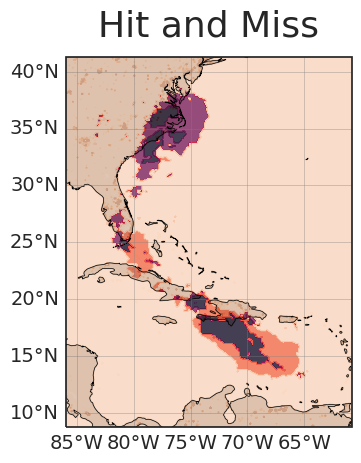

In [28]:
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
sns.set_style("white")
sns.set_context("notebook")
vmin=-2
vmax=2


fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
rain1 = np.sum(grid_rain,axis=0) > 50
rain2 = np.sum(grid_rain_truth,axis=0) > 50
hit = (rain1 == True) & (rain2 == True)
miss = (rain1 == False) & (rain2 == True)
false_alarm = (rain1 == True) & (rain2 == False)
correct_rejection = (rain1 == False) & (rain2 == False)
rain_data = hit + 2* miss + 3* false_alarm + 4*correct_rejection
ax.contourf(lon,-lat + 12,data,levels=range(1,200000,20000), transform=ccrs.PlateCarree(),cmap='Oranges')
m = ax.contourf(grid_x,grid_y,rain_data, transform=ccrs.PlateCarree(),alpha=0.8)


ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)


# plt.contourf(storm.precipitation[0,:,:,0],storm.storm_lats[0,:,:],storm.storm_lons[0,:,:])


# ax.outline_patch.set_linewidth(0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
			linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
# ax.set_xticklabels(labelsize=20)
# ax.set_yticklabels(labelsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

precip_cmap,precip_norm = make_cmap(high_vals=True)
# cbar = plt.colorbar(c,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=ax)
# cbar.ax.tick_params(labelsize=8,width=0.5)
# cbar.ax.tick_params(labelsize=20)
# plt.colorbar(m, ticks=[1,2,3,4],label=['hit','miss','false alarm','correct rejection'])
# plt.legend(['Hit','Miss','False Alarm','Correct Rejection'],loc='lower left')
ax.set_extent([grid_x[0,0], grid_x[-1,-1], grid_y[0,0], grid_y[-1,-1]], crs=ccrs.PlateCarree())
ax.set_title('Hit and Miss',fontsize=26,pad=15)

37023


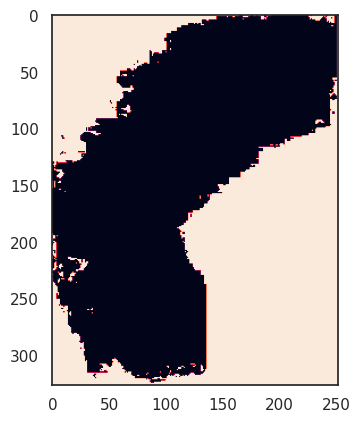

In [ ]:
plt.imshow(correct_rejection)
print(np.sum(correct_rejection))